# **IMDb Movie Reviews Sentiment Analysis**

## **Project Overview:**
This project analyzes **IMDb movie reviews** to extract meaningful insights.

The dataset contains 2 columns - **movie reviews** and their corresponding sentiment **labels (positive or negative)**.  

### **Key Objectives:**
- Exploring the distribution of sentiments in the dataset.
- Identifying common words in positive vs. negative reviews.
- Analyzing and reviewing length impact on sentiment.
- Determining if length impacts how extreme reviews are.
- Assessing the polarity and subjectivity of reviews.
- Extracting reviews that are most helpful or extreme.


---
**Name -** Anish Rao

**Student Number -** 20066423

**Course -** B9DA108: Programming for Data Analysis

**Group -** C

---

[*Dataset Link*](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)

---

[*Colab Notebook Link*](https://colab.research.google.com/drive/1T5Y68YAz2MWrdia0iPZ70jzqFE7d2E9S?usp=sharing)

## **Imports and Setup**

In [24]:
# Import necessary libraries
import os
import re
import warnings
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")

# Enable Bokeh output in the notebook
output_notebook()

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Set visualization style
sns.set_style("whitegrid")

dataset_filename = "IMDB Dataset.csv"
kaggle_dataset = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Dataset Loading and Overview**


In [25]:
def load_dataset():
    """
    Load the IMDb dataset from a local file or download it from Kaggle.

    Returns:
        pd.DataFrame: Loaded dataset as a DataFrame.
    """

    if os.path.exists(dataset_filename):
        print("File found locally. Loading dataset.")
        return pd.read_csv(dataset_filename)

    print("File not found. Fetching from Kaggle.")
    dataset_path = os.path.join(kaggle_dataset, "IMDB Dataset.csv")

    df = pd.read_csv(dataset_path)
    df.to_csv(dataset_filename, index=False)
    print("Dataset downloaded and saved locally.")
    return df

df = load_dataset()

# Display first 10 rows
df.head(10)

File not found. Fetching from Kaggle.
Dataset downloaded and saved locally.


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [26]:
# Dataset overview
print("Dataset Overview")
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print("="*70)

# Dataset information
print("\nDataset Information")
print(df.info())
print("="*70)

# Dataset summary
print("\nDataset Summary")
print(df.describe(include="all"))
print("="*70)

# Missing values
print("\nMissing values")
print(df.isnull().sum())
print("="*70)

# Duplicate reviews
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate reviews: {duplicate_count}")

Dataset Overview
Rows: 50000
Columns: 2

Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Dataset Summary
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

Missing values
review       0
sentiment    0
dtype: int64

Number of duplicate reviews: 418


## **Data Cleaning and Preprocessing**

In [27]:
def clean_text(text):
    """
    Clean review text by removing HTML tags, punctuation, and extra spaces.

    Args:
        text (str): The input review text.

    Returns:
        str: Cleaned text.
    """

    # lowercase
    text = text.lower()
    # html tags (e.g., <br />)
    text = re.sub(r'<.*?>', '', text)
    # punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_reviews(df):
    """
    Remove duplicates and clean review text.

    Args:
        df (pd.DataFrame): Raw dataset containing movie reviews.

    Returns:
        pd.DataFrame: Cleaned dataset.
    """

    df_cleaned = df.drop_duplicates(subset=['review'], keep='first').reset_index(drop=True)
    df_cleaned['cleaned_review'] = df_cleaned['review'].apply(clean_text)

    print(f"{len(df) - len(df_cleaned)} duplicate reviews removed.")
    print(f"Dataset shape after cleaning: {df_cleaned.shape}\n")
    return df_cleaned

df_cleaned = preprocess_reviews(df)
df_cleaned[['review', 'cleaned_review']].head(8)

418 duplicate reviews removed.
Dataset shape after cleaning: (49582, 3)



,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...
5,"Probably my all-time favorite movie, a story o...",probably my alltime favorite movie a story of ...
6,I sure would like to see a resurrection of a u...,i sure would like to see a resurrection of a u...
7,"This show was an amazing, fresh & innovative i...",this show was an amazing fresh innovative idea...


## **Exploratory Data Analysis (EDA)**

### **1. Sentiment Distribution in Positive vs. Negative Reviews**
In this section, we are analyzing the distribution of sentiment labels (positive vs. negative) in the dataset. We will create a bar chart to show the count of reviews for each sentiment.


In [28]:
# Calculate counts and percentage for both sentiment
sentiment_counts = df_cleaned['sentiment'].value_counts()
sentiments = sentiment_counts.index.tolist()
counts = sentiment_counts.values.tolist()
percentages = ((sentiment_counts / len(df_cleaned)) * 100).round(2)

print("Sentiment Distribution:\n", sentiment_counts)
print("\nPercentage Distribution:\n", (percentages.astype(str) + "%"))
print("\n\n")

# Create ColumnDataSource
source = ColumnDataSource(data=dict(
    sentiment=sentiments,
    count=counts,
    percentage=percentages.tolist(),
    color=['#B0FC38' if s == 'positive' else '#E3242B' for s in sentiments]
))

# Create interactive Bokeh figure
p = figure(x_range=sentiments, height=400, width=600,
           title="Sentiment Distribution in IMDb Reviews",
           toolbar_location=None, tools="")

p.vbar(x='sentiment', top='count', width=0.5, source=source, fill_color="color")

# Add hover tool
hover = HoverTool(tooltips=[("Sentiment", "@sentiment"),
                            ("Count", "@count"),
                            ("Percentage", "@percentage%")])
p.add_tools(hover)

# Customize plot
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.axis_label = "Sentiment"
p.yaxis.axis_label = "Count"
p.title.text_font_size = "16pt"
p.xaxis.major_label_text_font_size = "14pt"
p.yaxis.major_label_text_font_size = "14pt"

# Display plot
show(p)

Sentiment Distribution:
 sentiment
positive    24884
negative    24698
Name: count, dtype: int64

Percentage Distribution:
 sentiment
positive    50.19%
negative    49.81%
Name: count, dtype: object





#### **Sentiment Distribution Insights**

- The dataset has a nearly balanced sentiment distribution, with positive reviews **(50.19%)** slightly outnumbering negative ones **(49.81%)**.
- This balance ensures equal representation of both viewpoints.

### **2. Most Common Words in Positive vs. Negative Reviews**
This section generates word clouds to visualize the most frequent words used in positive and negative reviews.

In [29]:
# Combine all reviews
positive_reviews = " ".join(df_cleaned[df_cleaned['sentiment'] == "positive"]['cleaned_review'])
negative_reviews = " ".join(df_cleaned[df_cleaned['sentiment'] == "negative"]['cleaned_review'])

print("Total number of words in positive reviews:", len(positive_reviews.split()))
print("Total number of words in negative reviews:", len(negative_reviews.split()))
print("\n" + "="*50)

def top_words(reviews):
    """
    Returns the top 10 most common words from reviews, excluding stopwords.

    Args:
        reviews (str): Combined text of all reviews.

    Returns:
        list: Top words and their counts.
    """
    words = [word for word in reviews.split() if word not in stop_words]
    return Counter(words).most_common(10)

# Top words for both sentiments
top_words = {
    "Positive": top_words(positive_reviews),
    "Negative": top_words(negative_reviews)
}

for sentiment, words in top_words.items():
    print(f"\nTop 10 Most Common Words in {sentiment} Reviews:")
    for word, count in words:
        print(f"{word}: {count}")

Total number of words in positive reviews: 5681185
Total number of words in negative reviews: 5543979


Top 10 Most Common Words in Positive Reviews:
film: 39285
movie: 35836
one: 25621
like: 16999
good: 14286
great: 12570
story: 12338
see: 11814
time: 11724
well: 10933

Top 10 Most Common Words in Negative Reviews:
movie: 47010
film: 34651
one: 24364
like: 21509
even: 14761
good: 13997
bad: 13906
would: 13483
really: 12084
time: 11350


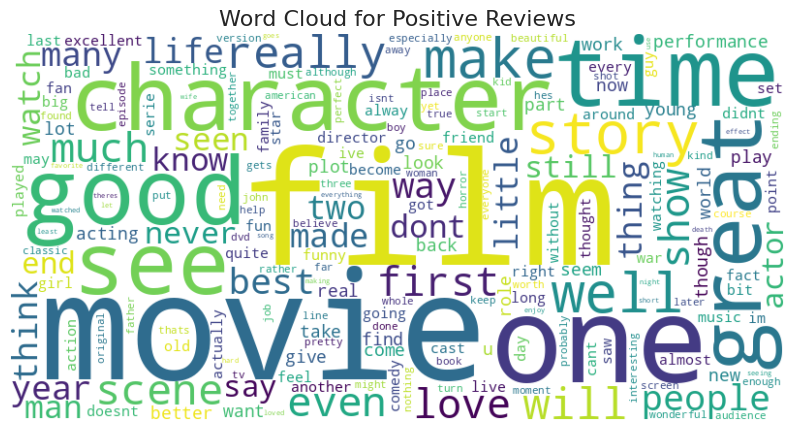

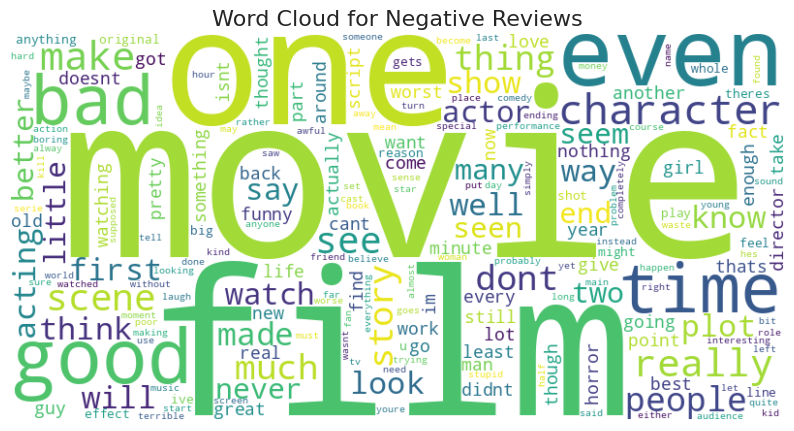

In [30]:
def create_wordcloud(reviews, title):
    """
    Displays a word cloud for the given review.

    Args:
        reviews (str): Combined text of all reviews for a sentiment.
        title (str): Title of the word cloud plot.

    Returns:
        None
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          collocations=False).generate(reviews)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Create word clouds for both sentiments
create_wordcloud(positive_reviews, "Word Cloud for Positive Reviews")
print("\n\n")
create_wordcloud(negative_reviews, "Word Cloud for Negative Reviews")

#### **Most Common Words Insights**

* Positive reviews include the words **"film," "movie," "great," "story,"** and **"time,"** suggesting that reviewers focus on the quality of the story and overall enjoyment.
* Negative reviews also highlight **"film"** and **"movie,"** but words like **"bad," "even,"** and **"really,"** indicating stronger dissatisfaction are also used a lot.
* The common words suggests that although both sentiments discuss similar aspects, their tone and context significantly differ.

### **3. Review Length Analysis: Short vs. Long Reviews**
In this section, we analyzed the review length to see if longer reviews tend to be of a specific sentiment by calculating word counts and visualizing trends.

In [31]:
# Calculate review length
df_cleaned['review_length'] = df_cleaned['cleaned_review'].apply(lambda x: len(x.split()))

print("Review Length Statistics:")
print(df_cleaned['review_length'].describe())
print("\n" + "="*80)
print(df_cleaned.groupby('sentiment')['review_length'].describe())

Review Length Statistics:
count    49582.000000
mean       226.395950
std        167.728067
min          4.000000
25%        124.000000
50%        170.000000
75%        275.000000
max       2450.000000
Name: review_length, dtype: float64

             count        mean         std   min    25%    50%    75%     max
sentiment                                                                    
negative   24698.0  224.470767  161.154345   4.0  125.0  171.0  272.0  1473.0
positive   24884.0  228.306743  173.989442  10.0  123.0  169.0  277.0  2450.0


In [32]:
# Plot histogram of review lengths
hist, edges = np.histogram(df_cleaned['review_length'], bins=50)
source_hist = ColumnDataSource(data=dict(
    top=hist,
    left=edges[:-1],
    right=edges[1:]
))

# Create interactive Bokeh figure
p_hist = figure(title="Distribution of Review Lengths",
                x_axis_label="Review Length",
                y_axis_label="Frequency",
                width=800, height=400)

p_hist.quad(top='top', bottom=0, left='left', right='right', source=source_hist,
            fill_color="limegreen", line_color="black", alpha=0.7)

# Add hover tool
hover_hist = HoverTool(tooltips=[("Range",
                                  "@left{0} to @right{0}"),
                                   ("Count", "@top")])
p_hist.add_tools(hover_hist)

# Display histogram
show(p_hist)

In [33]:
# Count reviews with lengths between 100-150 words
reviews_100_150 = df_cleaned[(df_cleaned['review_length'] >= 100) & (df_cleaned['review_length'] <= 150)].shape[0]

# Count reviews with lengths more than 1000 words
reviews_above_1000 = df_cleaned[df_cleaned['review_length'] > 1000].shape[0]

print(f"Number of reviews between 100-150 words: {reviews_100_150}")
print(f"Number of reviews more than 1000 words: {reviews_above_1000}")

Number of reviews between 100-150 words: 14140
Number of reviews more than 1000 words: 41


#### **Review Length Insights**

* Review length is similar across sentiments, negative reviews averaging **224** words and positive reviews averaging **228** words.
* Most reviews are short, with **14,140** reviews **(28.5%)** having between **100-150** words.
* Very long reviews are rare, with only **41** reviews exceeding **1,000** words.
* Positive reviews show slightly higher variance, with a maximum length of **2,450** words compared to **1,473** words for negative reviews.
* Overall, sentiment does not have strong influence review length, as both positive and negative reviews follow a similar pattern.

### **4. Sentiment Intensity in Short vs. Long Reviews**
We analyzed whether shorter reviews expressed more extreme sentiments or not by comparing sentiment polarity with the review length.


Sentiment Polarity Statistics:
count    49582.000000
mean         0.101630
std          0.161207
min         -1.000000
25%          0.003490
50%          0.102806
75%          0.200885
max          1.000000
Name: polarity, dtype: float64


Correlation between Review Length and Sentiment Polarity:
                review_length  polarity
review_length       1.000000 -0.049594
polarity           -0.049594  1.000000




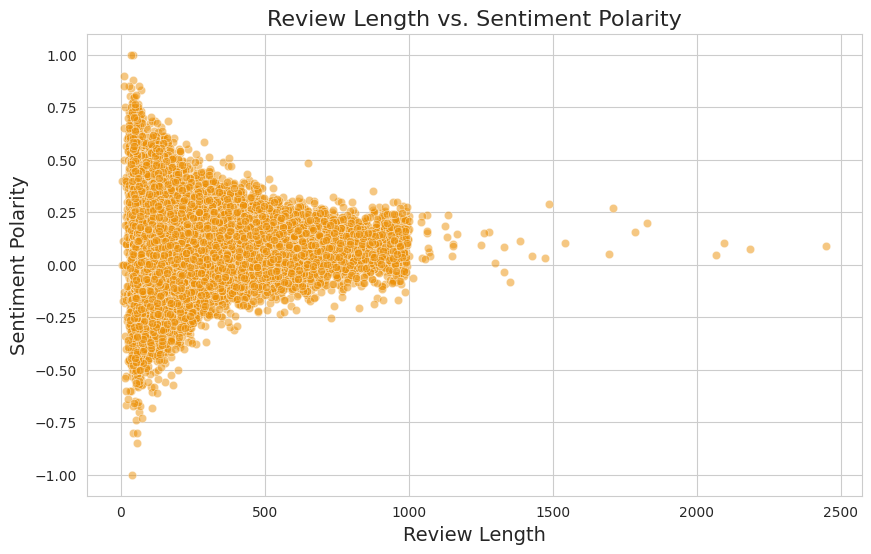

In [34]:
# Calculate polarity
df_cleaned['polarity'] = df_cleaned['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

print("Sentiment Polarity Statistics:")
print(df_cleaned['polarity'].describe())
print("\n")

# correlation between review length and polarity
correlation = df_cleaned[['review_length', 'polarity']].corr()
print("Correlation between Review Length and Sentiment Polarity:\n", correlation)
print("\n")

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_length', y='polarity', data=df_cleaned, alpha=0.5, color='#EC9006')
plt.title("Review Length vs. Sentiment Polarity", fontsize=16)
plt.xlabel("Review Length", fontsize=14)
plt.ylabel("Sentiment Polarity", fontsize=14)
plt.show()

#### **Sentiment Intensity in Short vs. Long Reviews Insights**

* The weak negative correlation **(-0.049)** means that as review length increases, sentiment polarity slightly decreases, which means longer reviews have less extreme opinions.
* Short reviews (**<200** words) frequently have very high or very low polarity, showing stronger emotions.
* Long reviews (**>500** words) cluster around neutral sentiment, meaning they focus more on detailed analysis of the movie rather than emotional extremes.
* Overall, this indicates that users who write brief reviews tend to express stronger emotions, while longer reviews are more balanced.


### **5. Polarity & Subjectivity of Reviews**
We examine the overall sentiment polarity and subjectivity of reviews and visualize their distributions with histograms.


In [35]:
# Calculate subjectivity
df_cleaned['subjectivity'] = df_cleaned['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

print("Review Subjectivity Statistics:")
print(df_cleaned['subjectivity'].describe())
print("\n")

# Count reviews based on polarity ranges
polarity_ranges = {
    "Highly Negative (-1 to -0.5)": df_cleaned[(df_cleaned['polarity'] <= -0.5)].shape[0],
    "Moderately Negative (-0.5 to 0)": df_cleaned[(df_cleaned['polarity'] > -0.5) & (df_cleaned['polarity'] < 0)].shape[0],
    "Neutral (0)": df_cleaned[df_cleaned['polarity'] == 0].shape[0],
    "Moderately Positive (0 to 0.5)": df_cleaned[(df_cleaned['polarity'] > 0) & (df_cleaned['polarity'] <= 0.5)].shape[0],
    "Highly Positive (0.5 to 1)": df_cleaned[(df_cleaned['polarity'] > 0.5)].shape[0]
}

# Count reviews based on subjectivity ranges
subjectivity_ranges = {
    "Highly Objective (0 to 0.3)": df_cleaned[(df_cleaned['subjectivity'] <= 0.3)].shape[0],
    "Moderately Objective (0.3 to 0.5)": df_cleaned[(df_cleaned['subjectivity'] > 0.3) & (df_cleaned['subjectivity'] <= 0.5)].shape[0],
    "Moderately Subjective (0.5 to 0.7)": df_cleaned[(df_cleaned['subjectivity'] > 0.5) & (df_cleaned['subjectivity'] <= 0.7)].shape[0],
    "Highly Subjective (0.7 to 1)": df_cleaned[(df_cleaned['subjectivity'] > 0.7)].shape[0]
}

print("Polarity Distribution:")
for key, value in polarity_ranges.items():
    print(f"{key}: {value} reviews")

print("\nSubjectivity Distribution:")
for key, value in subjectivity_ranges.items():
    print(f"{key}: {value} reviews")

Review Subjectivity Statistics:
count    49582.000000
mean         0.530600
std          0.092784
min          0.000000
25%          0.472421
50%          0.528820
75%          0.587449
max          1.000000
Name: subjectivity, dtype: float64


Polarity Distribution:
Highly Negative (-1 to -0.5): 57 reviews
Moderately Negative (-0.5 to 0): 11954 reviews
Neutral (0): 33 reviews
Moderately Positive (0 to 0.5): 37067 reviews
Highly Positive (0.5 to 1): 471 reviews

Subjectivity Distribution:
Highly Objective (0 to 0.3): 439 reviews
Moderately Objective (0.3 to 0.5): 17672 reviews
Moderately Subjective (0.5 to 0.7): 29653 reviews
Highly Subjective (0.7 to 1): 1818 reviews


In [36]:
def plot_histogram(data, title, x_label, color):
    """
    Generates an interactive histogram.

    Args:
        data (pd.Series): The data to plot.
        title (str): The title of the plot.
        x_label (str): Label for the x-axis.
        color (str): Fill color for the histogram.

    Returns:
        None
    """
    hist, edges = np.histogram(data, bins=50)
    source = ColumnDataSource(data=dict(top=hist, left=edges[:-1], right=edges[1:]))

    p = figure(title=title, x_axis_label=x_label, y_axis_label="Frequency",
               width=800, height=400, x_range=(edges[0], edges[-1]))

    p.quad(top='top', bottom=0, left='left', right='right', source=source,
           fill_color=color, line_color="white", alpha=0.7)

    hover = HoverTool(tooltips=[("Range", "@left{0.00} to @right{0.00}"), ("Count", "@top")])
    p.add_tools(hover)

    show(p)

# histograms for polarity and subjectivity
plot_histogram(df_cleaned['polarity'], "Distribution of Sentiment Polarity", "Polarity", "green")
print("\n")
plot_histogram(df_cleaned['subjectivity'], "Distribution of Review Subjectivity", "Subjectivity", "orange")

#### **Sentiment Polarity & Subjectivity Insights**

*Polarity Distribution:*
* Most reviews **(74.7%)** are moderately positive **(0 to 0.5)**, showing a general bias toward positive sentiment.
* Moderately negative reviews **(-0.5 to 0)** make up **24.1%**, meaning negative reviews exist but are less extreme.
* Highly polarized reviews are rare, with only **57** highly negative and **471** highly positive reviews.

*Subjectivity Distribution:*
* Most reviews **(59.8%)** are moderately subjective **(0.5 to 0.7)**, meaning reviews have opinions but are not exaggerated.
* Only **0.88%** of reviews are extremely objective, meaning that purely factual reviews are rare.
* Extremely subjective reviews **(3.6%)** are also uncommon, suggesting that most users provide a mix of opinion and fact.

Final Insight: Reviews tend to be opinionated but not overly extreme.



### **6. Most Helpful Reviews Based on Length & Sentiment Strength**
Since the dataset does not have helpfulness ratings, we considered reviews with extreme sentiment or longer length as likely to be more detailed and helpful.


In [37]:
# Absolute polarity to identify extreme sentiments
df_cleaned['abs_polarity'] = df_cleaned['polarity'].abs()

# Top 5 most extreme sentiment
top_extreme = df_cleaned.sort_values(by='abs_polarity', ascending=False).head(5)
print("Top 5 Reviews with Extreme Sentiment:\n")
display(top_extreme[['review', 'cleaned_review', 'polarity', 'review_length']])

print("="*120)

# Top 5 longest reviews
top_long = df_cleaned.sort_values(by='review_length', ascending=False).head(5)
print("\n\nTop 5 Longest Reviews:\n")
display(top_long[['review', 'cleaned_review', 'review_length', 'polarity']])

Top 5 Reviews with Extreme Sentiment:



,review,cleaned_review,polarity,review_length
11973,This movie had me smiling from beginning to en...,this movie had me smiling from beginning to en...,1.0000,44
21532,Farley and Spade's best work ever. It's one of...,farley and spades best work ever its one of th...,1.0000,35
13865,This movie was horrible and corny. James Agee ...,this movie was horrible and corny james agee i...,-1.0000,38
18342,Brilliant and moving performances by Tom Court...,brilliant and moving performances by tom court...,0.9000,10
12484,"I felt a great joy, after seeing this film, no...",i felt a great joy after seeing this film not ...,0.8775,41




Top 5 Longest Reviews:



,review,cleaned_review,review_length,polarity
31309,Match 1: Tag Team Table Match Bubba Ray and Sp...,match 1 tag team table match bubba ray and spi...,2450,0.089456
40247,There's a sign on The Lost Highway that says:<...,theres a sign on the lost highway that saysmaj...,2186,0.075269
31265,"Back in the mid/late 80s, an OAV anime by titl...",back in the midlate 80s an oav anime by title ...,2094,0.102263
31072,"(Some spoilers included:)<br /><br />Although,...",some spoilers includedalthough many commentato...,2068,0.047715
12622,Titanic directed by James Cameron presents a f...,titanic directed by james cameron presents a f...,1827,0.199990


#### **Extreme and Detailed Reviews Insights**

* Extreme sentiment reviews are short **(10-44 words)**, with highly positive reviews **(polarity = 1.0)** being enthusiastic and highly negative reviews **(polarity = -1.0)** being strongly critical.
* Longest reviews **(2,000+ words)** are more neutral **(0.04 - 0.19)**, suggesting that detailed reviews focus on discussion rather than strong emotions.
* Final Insight: Short reviews tend to be emotionally intense, while long reviews prioritize details of the movie.


### **Conclusion**

This analysis of IMDb reviews provided key insights into sentiment trends, word usage, review lengths, and intensity of sentiments.

The dataset showed a balanced sentiment distribution, with moderately positive reviews being most common. Short reviews were more emotionally intense, while longer reviews tended to be neutral and analytical.

The existence of highly subjective reviews indicates that discussions were mostly shaped by personal opinions, with extreme reviews being brief and to the point.